In [41]:
import os
os.chdir(r'C:\Users\TYC\Documents\Year 2 Sem 3 Resources\MP\Tutorial Notes\Week 6')

import sys
# Python 3.7 is required
assert sys.version_info >= (3,7)

import cv2 as cv
import numpy as np

# Make sure that optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

import matplotlib.pyplot as plt

### 1) Write a program to segment the boat and the people on it from the background. Follow the instruction below:
- Use 'boat.jpg' as input.
- Apply Otsu thresholding.
- Draw bounding box to identify the region where the boat and people are located.

In [42]:
img = cv.imread('boat.jpg', 0)   # 0 means grayscale

# Otsu's threshold after Gaussian filtering
blur = cv.GaussianBlur(img, (5, 5), 0)   # the third argument here is standard deviation
ret3, th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

#define initial minimum and maximum x and y values for pixels with value 255
xmin, xmax, ymin, ymax = th3.shape[1]-1, 0, th3.shape[0]-1, 0

#dilate mask so that bounding box would be slightly larger than actual boat
struc_ele=np.ones((5,5),dtype=np.uint8)
th3=cv.dilate(th3,struc_ele,iterations=5)

#brute force pixel by pixel identification of min and max x and y, O(width*height) time complexity, not ideal
for i in range(th3.shape[0]):
    for j in range(th3.shape[1]):
        if(th3[i][j]==255):
            xmin=min(xmin,j)
            xmax=max(xmax,j)
            ymin=min(ymin,i)
            ymax=max(ymax,i)

#load initial boat image
img = cv.imread('boat.jpg')

#create bounding box based on min and max x and y on the loaded boat image
cv.rectangle(img,(xmin,ymin),(xmax,ymax),(0,0,255), 1, cv.LINE_AA)

cv.imshow('Bounding box', img)
cv.waitKey(0)
cv.destroyAllWindows()

### 2) Write a program to visualize the effect of size of structuring element on the morphological transformation (e.g. erosion, dilation, opening, and closing).

- Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
- Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window - alongside the trackbar.

In [43]:
img=cv.imread('leaf.jfif')
ret, img = cv.threshold(img, 200, 255, cv.THRESH_BINARY)
size=4

#kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE, (size, size))
#img1 = cv.morphologyEx(img,cv.MORPH_ELLIPSE,kernel)

def trackbar(x):
    kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE, (x,x))
    img1 = cv.morphologyEx(img,cv.MORPH_ERODE,kernel)
    img2 = cv.morphologyEx(img,cv.MORPH_DILATE,kernel)
    img3 = cv.morphologyEx(img,cv.MORPH_OPEN,kernel)
    img4 = cv.morphologyEx(img,cv.MORPH_CLOSE,kernel)
    cv.imshow('window',np.vstack([img,img1,img2,img3,img4]))
    
cv.namedWindow('window')
cv.createTrackbar('size','window',50,100,trackbar)

#cv.imshow('leaf',img)
cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\filterengine.hpp:367: error: (-215:Assertion failed) anchor.inside(Rect(0, 0, ksize.width, ksize.height)) in function 'cv::normalizeAnchor'


### 3) Apply the steps shown in exercise 4 to segment the porcelain from these images: "porcelain1.jfif" - "porcelain5.jfif".

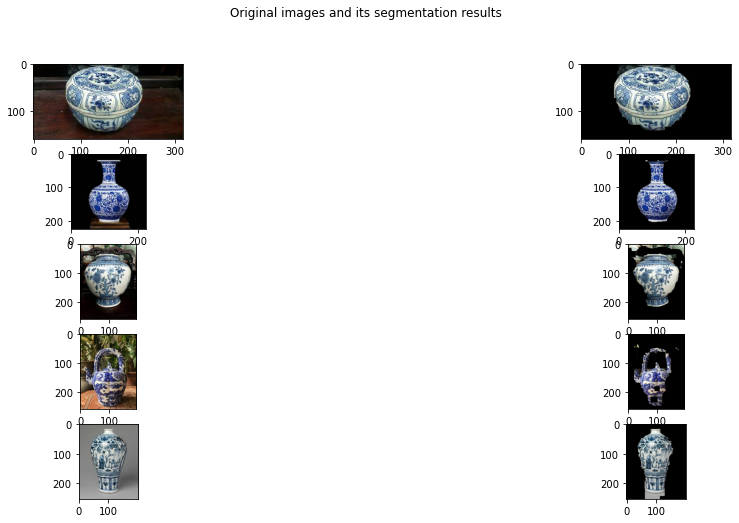

In [44]:
#load images into a list, blur the image and convert them from BGR to HSV format, save a copy of BGR image to be used for masking and segmenting at the end
imgs=[]
imgs_copy=[]   #stores copy of image that has hgih frequency detail that will be used for masking at the end
for i in range(5): 
    img=cv.imread('porcelain{}.jfif'.format(i+1))
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    imgs_copy.append(img)
    img=cv.medianBlur(img,3) #blur image to lessen the contrast and obtain smoother masks
    img=cv.cvtColor(img,cv.COLOR_RGB2HSV)
    imgs.append(img)
    
#create a list of masks for each image for segmenting blue, range is obtained from 3d hsv plot
blue_light=(50, 50, 50)
blue_dark=(130, 250, 250)
mask1=[]
res1=[]
for i in range(len(imgs)): 
    mask1.append(cv.inRange(imgs[i], blue_light, blue_dark))
    res1.append(cv.bitwise_and(imgs[i],imgs[i],mask=mask1[i]))

#create a list of masks for each image for segmenting white, range is obtained from 3d hsv plot, white mask is combined with blue mask 
white_light=(25,0,140)
white_dark=(100,50,255)
mask2=[]
res2=[]
final_mask=[]
for i in range(len(imgs)): 
    mask2.append(cv.inRange(imgs[i], white_light, white_dark))
    res2.append(cv.bitwise_and(imgs[i],imgs[i],mask=mask2[i]))
    final_mask.append(cv.bitwise_or(mask1[i],mask2[i]))

#fill up the gaps with erosion and dilation, then mask the final mask onto the original procelain images
kernel = np.ones((5,5), np.uint8)
res=[]
for i in range(len(imgs)): 
    final_mask[i] = cv.dilate(final_mask[i], kernel, iterations = 4)
    final_mask[i] = cv.erode(final_mask[i], kernel, iterations = 4)
    final_mask[i] = cv.cvtColor(final_mask[i],cv.COLOR_GRAY2RGB)
    imgs[i]=cv.cvtColor(imgs[i],cv.COLOR_HSV2RGB)
    res.append(cv.bitwise_and(imgs_copy[i],final_mask[i]))

#display images and it's segmented counterpart
f, ax = plt.subplots(5,2,figsize=(18,8))
for i in range(5):
    ax[i][0].imshow(imgs_copy[i])
    ax[i][1].imshow(res[i])
f.suptitle('Original images and its segmentation results')
plt.show()